# Seminarios de Procesos Gaussianos

### Grupo de procesamiento de la información visual (VIP) 

<div style="text-align: right"> Miguel López Pérez </div>

En primer lugar, como para un buen conocimiento teórico de los procesos gaussianos recomendamos la siguiente bibliografía:

- [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) de Carl Edward Rasmussen and Christopher K. I. Williams
- *Machine learning : a probabilistic perspective* de Kevin Murphy
- [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) de Christopher Bishop

# 0. Librerías a usar

Los ejemplos de estos notebooks van a estar basados en la librería gpflow. Es una extensión de GPy con la ventaja 
de que se pueden cargar cálculos en la GPU al estar basado en tensorflow. Al ser un proyecto open source podemos acceder a su [documentación](https://gpflow.readthedocs.io/en/develop/intro.html) y [código](https://github.com/GPflow/GPflow/tree/master). También nos hará falta tener instalada la librería scikit-learn.

In [3]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
%matplotlib inline

# 1. Kernels

#### Definición de proceso gaussiano

Un proceso gaussiano (GP) es una colección de variables aleatorias de tal forma que cada subconjunto finito de ellas sigue una distribución normal multivariante.
Se denota como $f(\mathbf{x})\sim\mathcal{GP}\left(m(\mathbf{x}),k(\mathbf{x},\mathbf{x'})\right)$. Donde $m(\mathbf{x})$ es la función de media y $k(\mathbf{x},\mathbf{x'})$  es una función kernel que nos definirá la covarianza para cada par de variables $\mathbf{x}$ y $\mathbf{x}'$. La única condición para la función kernel es que nos genere una matriz semidefinida positiva para poder obtener una distribución de probabilidad.

Para cualquier muestra $\mathbf{X}=\{\mathbf{x}_1,\dots,\mathbf{x}_n\}$ tendremos definido sobre nuestra función $f$ una distribución normal multivariante (en este caso de $n$ dimensiones). Esto se usará como información a priori para los problemas de regresión o clasificación. Usando este planteamiento bayesiano, podremos imponerle propiedades deseables a la función latente que queremos estimar $f$.

La media suele ser constante igual a 0 sin perder generalidad o flexibilidad. La cuestión será construir la función kernel $k$. Esta será la encargada de aportar las características o propiedades a la función $f$ que queremos modelar. Esta función nos dará la matriz de convarianza y, por tanto, la dependencia entre dos instancias. Entre las características que podemos imponer a nuestro GP será suavidad o periodicidad. 


**Nótese** que estas funciones kernels dependerán a su vez de parámetros los cuales regularán estas propiedades.

### Ejemplo de proceso gaussiano

En este ejemplo, vamos a consider que $x_1,\dots,x_n$ son números reales. Entonces podremos definir a través de nuestro $\mathcal{GP}$ una distribución normal multivariante para cada subconjunto finito de números reales.

 $f({x})\sim\mathcal{GP}\left(0,k({x},{x'})\right)$
 
 Consideramos la función kernel $k$ exponencial cuadrada (SE) (también conocida como Radial Basis Function (RBF)), que se define como
 
 $$ k(x, x') = \exp\left(-\frac{\parallel x - x'\parallel_2^2}{0.5}\right)$$.
 
 
Si tenemos una muestra que sea ${X}=\{0.1,0.2,0.8\}$, la función $f({x})$ tendrá la siguiente distribución:

$$f\sim\mathcal{N}(0, K), \qquad K = \begin{pmatrix}
1 & 0.9801 & 0.3753 \\
0.9801 & 1 & 0.4867 \\
0.3753 & 0.4867 & 1
\end{pmatrix}$$

Como podemos ver en la matriz de covarianza, el punto 0.1 y 0.2 tienen una dependencia (0.9801) más alta que cada uno de ellos con 0.8 (0.3753, 0.4867). Además cuanto más lejanos están los puntos menor es la dependencia. Esto nos garantiza que valores cercanos en $x, ~  x'$ (entrada) deberán tener valores parecidos su función latente $f(x), ~  f(x')$ (salida), esto sería un concepto de suavidad. 

** Recuerda **: La única condición puesta para esta función kernel es que se debe obtener una matriz semidefinida positiva, de otro modo no nos definiría una distribución de probabilidad.

En la siguiente celda vamos a dibujar 3 muestreos de esta distribución:

In [1]:
np.random.seed(100) #Semilla para que siempre nos salgan las mismas muestras
k = gpflow.kernels.RBF(1, lengthscales = 0.5, variance = 1) #Definición del kernel
xx = np.array([[0.1], [0.2], [0.8]]) #Puntos de entrada
K = k.compute_K_symm(xx) #Cálculo de la matriz de covarianzas de la malla definida
plt.plot(xx, np.random.multivariate_normal(np.zeros(len(xx)), K, 3).T,  'o', markersize = 12) #Tomamos 3 muestras de la distribución
plt.title('3 muestras de la distribución de f')
plt.show()

NameError: name 'np' is not defined

Podemos tener más puntos de entradas y muestrear en la multivariante resultante, por ejemplo ${X}=\{0.1,0.12,0.2,0.4,0.7,0.71,0.75\}$

Text(0.5, 1.0, '3 muestras de la distribución de f')

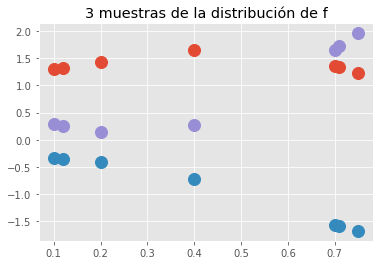

In [53]:
np.random.seed(50) #Semilla para que siempre nos salgan las mismas muestras
k = gpflow.kernels.RBF(1, lengthscales = 0.5, variance = 1) #Definición del kernel
xx = np.array([[0.1], [0.12], [0.2], [0.4], [0.7], [0.71], [0.75]]) #Puntos de entrada
K = k.compute_K_symm(xx) #Cálculo de la matriz de covarianzas de la malla definida
plt.plot(xx, np.random.multivariate_normal(np.zeros(len(xx)), K, 3).T, 'o', markersize = 12) #Tomamos 3 muestras de la distribución
plt.title('3 muestras de la distribución de f')

La idea es que si nuestro conjunto de entrada es una malla lo suficientemente fina de puntos (y entre los puntos unimos con rectas) podremos obtener funciones continuas en los muestreos ya que nuestro GP nos define la distribución multivariante para cualesquiera puntos de entrada:

Text(0.5, 1.0, '3 muestras de la distribución de f')

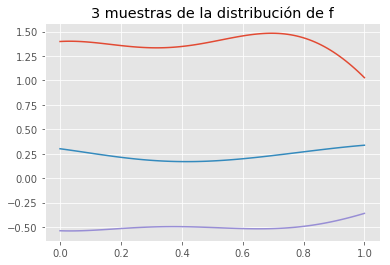

In [52]:
np.random.seed(50) #Semilla para que siempre nos salgan las mismas muestras
k = gpflow.kernels.RBF(1, lengthscales = 0.5, variance = 1) #Definición del kernel
xx =  np.linspace(0, 1, 100)[:,None] #Puntos de entrada
K = k.compute_K_symm(xx) #Cálculo de la matriz de covarianzas de la malla definida
plt.plot(xx, np.random.multivariate_normal(np.zeros(len(xx)), K, 3).T) #Tomamos 3 muestras de la distribución
plt.title('3 muestras de la distribución de f')
plt.show()

**Resumen:** La distribución a priori de $f$ vendrá definida por el kernel que elijamos el cual regulará las propiedades de esta función. A su vez estas funciones kernel dependerán de parámetros que también controlarán estas propiedades.

## Ejemplos de kernels

La siguiente función auxiliar nos muestreará el kernel que le digamos en el intervalo (-3,3).

In [2]:
#Función para dibujar un muestreo de los kernels
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:,None] #Definimos una malla en el eje x
    K = k.compute_K_symm(xx) #Cálculo de la matriz de covarianzas de la malla definida
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T) #Pintamos 3 muestras de la normal multivariante de media 0 y matriz de covarianza K
    ax.set_title(k.__class__.__name__) #El título del gráfico será el nombre del kernel

A continuación, vemos ejemplos de algunos los kernels más utilizados:

** Función lineal **

 $$\text{Lineal}\quad k(x, x') = \sigma^2 x \cdot x'$$

** Función Estática **

 $$\text{White}\quad k(x, x') = \sigma^2\delta_{x x'}$$

** Funciones estacionarias: ** $r = \frac{\parallel x - x'\parallel_2}{l}$


 $$\text{Matern12}\quad k(x, x') = \sigma^2\exp\left(-r\right)$$ 

 $$\text{Matern32}\quad k(x, x') = \sigma^2(1+\sqrt{3}r)\exp\left(-\sqrt{3}r\right)$$
 
  $$\text{Matern52}\quad k(x, x') = \sigma^2(1+\sqrt{5}r + \frac{5}{3}r)\exp\left(-\sqrt{5}r\right)$$
 
 $$\text{RBF}\quad k(x, x') = \sigma^2\exp\left(-\frac{r^2}{2}\right)$$
 
** Funciones periódicas **

 $$\text{Coseno}\quad k(x, x') = \sigma^2\cos\left(r^2\right)$$
 
  $$\text{Periódica}\quad k(x, x') = \sigma^2\exp\left(-\frac{\frac{1}{p}\sin(\pi{\parallel x-x'\parallel_2^2})}{l}\right)$$



El *núcleo lineal* nos introducirá como información a priori la linealidad de los datos, estaremos haciendo regresión lineal. La función *white* es una función de ruido gaussiano, la cual se suele añadir aditivamente a otros kernels para evitar overfitting. Las *funciones estacionarias* dependen de r, es decir, solo importa la distancia entre dos puntos. Por último, las *funciones periódicas* impondrá una dependencia periódica.

Dentro de las *funciones estacionarias* hay algunas que imponen más suaviadad que otras. Nótese esto en el ejemplo.

Obtenemos 3 muestras de cada kernel en el intervalo (-3,3) para ver que propiedades pueden tener cada uno:

In [2]:
np.random.seed(100)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(1), axes[0,0])
plotkernelsample(gpflow.kernels.Matern32(1), axes[0,1])
plotkernelsample(gpflow.kernels.Matern52(1), axes[0,2])
plotkernelsample(gpflow.kernels.RBF(1), axes[0,3])
plotkernelsample(gpflow.kernels.White(1), axes[1,0])
plotkernelsample(gpflow.kernels.Linear(1), axes[1,1])
plotkernelsample(gpflow.kernels.Cosine(1), axes[1,2])
plotkernelsample(gpflow.kernels.Periodic(1), axes[1,3])
axes[0,0].set_ylim(-3, 3)

NameError: name 'np' is not defined

## Kernel RBF

El kernel más utilizado es el Exponencial Cuadrado (SE) o Radial Basis Function (RBF):

$$ k(x, x') = \sigma^2\exp\left(-\frac{\parallel x - x'\parallel_2^2}{2l^2}\right)$$.
 
 
Este kernel aporta suavidad a la función lo cual será algo deseable, normalmente. Además tiene suficiente flexibilidad para poder aproximar diversas funciones. Podemos regular estas propiedades eligiendo los parámetros de escala ($l$) y varianza ($\sigma$).

En el siguiente script, prueba distintos valores de escala ($l$ ó $sc$) y varianza ($var$) para ver en qué afecta a la función resultante.

In [ ]:
#Parámetros del kernel
var = 1
sc = 10

#Semilla aleatoria
np.random.seed(100)
k = gpflow.kernels.RBF(input_dim = 1, lengthscales = sc, variance = var)

f, axes = plt.subplots(1 , 1, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.RBF(input_dim = 1, lengthscales = sc, variance = var), axes)

x_title = 'k(x,y) = {} exp [- {} ||x - y ||$^2$]'.format(var, 1/sc)
axes.set_xlabel(x_title)


print(k)

**Pregunta:** ¿Cómo afecta la escala y la varianza a las funciones resultantes?

## Construcción de nuevos kernels

A partir de estos kernels vistos se pueden construir nuevos. Una referencia de esto la podemos encontrar en el [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/). 

### Suma de kernels

Podemos considerar la suma de dos kernels para obtener un nuevo kernel. En este ejemplo definimos la siguiente función kernel que es la suma de un RBF con un kernel de ruido blanco:

$$k(x,x') = k_{RBF}(x,x') + k_{White}(x,x')$$

donde $k_{RBF}$ y $k_{White}$ son las funciones kernels definidas anteriormente. Nótese que la suma de dos matrices de covarianza nos da otra matriz de covarianza (es fácil ver que la suma de dos matrices semidefinidas positiva da otra matriz semidefinida positiva).

In [4]:
k = gpflow.kernels.RBF(1) + gpflow.kernels.White(1, 1e-3)
np.random.seed(100)
f, axes = plt.subplots(1 , 1, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(k, axes)

NameError: name 'gpflow' is not defined

**Pregunta:** ¿Qué pasaría si sumaramos un kernel periódico con uno lineal?

### Multiplicación de kernels

De manera similar podemos considerar la multiplicación de kernels, en este ejemplo mostramos:
    
$$k(x,x') = k_{Lineal}(x,x') * k_{Lineal}(x,x')$$

In [ ]:
k = gpflow.kernels.Linear(1) * gpflow.kernels.Linear(1)
np.random.seed(100)
f, axes = plt.subplots(1 , 1, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(k, axes)

**Pregunta:** ¿Qué pasaría si multiplicaramos 3 kernels lineales?

## Kernels en varias dimensiones

### Dimensiones activas

Podemos aplicar determinados kernels en dimensiones específicas. Por ejemplo, en un caso 2D. Cada instancia $\mathbf{x}_1, \dots, \mathbf{x}_n$ tendrá dos rasgos o coordenadas: $\mathbf{x}_1=(x_1^1,x_1^2)$. En el caso de RBF de manera general este kernel se definiría como:


Podemos elegir sobre que coordenada debe actuar el kernel, por ejemplo, podemos calcular la matriz de varianza usando solo la primera coordenada:


In [ ]:
k1 = gpflow.kernels.Linear(1, active_dims=[0])
k2 = gpflow.kernels.Matern52(1, active_dims=[1])
k = k1 + k2
k.as_pandas_table()

### Automatic relevance determination

Esto significa que estamos poniendo un parámetro de escala $l$ distinto en cada dimensión. Esto hará que no todas las dimensiones contribuyan por igual. Cuando estimemos estos parámetros de escalas nos indicará la relevancia de cada dimensión ya que valores más altas denotan una dependencia más alta en esa dimensión respecto de la variable objetivo.

In [ ]:
k1 = gpflow.kernels.RBF(5, ARD = True)
k1.as_pandas_table()